In [2]:
import pandas as pd
import os
from itables import show
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler

In [3]:
#finding out how many cpu cores you have
!wmic cpu get NumberOfCores,NumberOfLogicalProcessors

#divide the work between the existing cores - 1
os.environ['OMP_NUM_THREADS']='7'

NumberOfCores  NumberOfLogicalProcessors  

4              8                          





# Prepare data set for prediction

In [4]:
traffic = pd.read_csv('traffic.csv')
weather = pd.read_csv('weather_data.csv')
emissions = pd.read_csv('emission_huegelstr.csv')

In [4]:
weather

,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],datetime
0,1004.0,61.0,11.5,2.6,235.0,2018-01-01 00:30:00
1,1004.0,62.7,11.0,2.7,244.0,2018-01-01 01:00:00
2,1004.0,64.0,10.7,2.0,229.0,2018-01-01 01:30:00
3,1004.0,65.5,10.4,2.1,235.0,2018-01-01 02:00:00
4,1005.0,65.0,10.2,2.6,243.0,2018-01-01 02:30:00
...,...,...,...,...,...,...
100143,1007.0,85.2,18.9,0.8,166.0,2023-09-18 08:00:00
100144,1007.0,81.6,19.4,0.9,157.0,2023-09-18 08:30:00
100145,1007.0,79.8,19.8,1.2,173.0,2023-09-18 09:00:00
100146,1007.0,76.4,20.4,1.2,176.0,2023-09-18 09:30:00


In [5]:
pred_data = traffic.merge(weather, how='left', left_on= 'roundedTimestamp', right_on='datetime').merge(emissions[['PM10','PM2,5', 'NO2','datetime']], how='left', left_on= 'roundedTimestamp', right_on='datetime' )
pred_data.drop(columns=['datetime_y', 'roundedTimestamp'], inplace = True)
show(pred_data)

df = pred_data.copy()

In [6]:
df.index = pd.to_datetime(df['datetime_x'], format='%Y-%m-%d %H:%M:%S')
df[:26]

,Bezeichnung,D1Z,D2Z,D3Z,D4Z,D5Z,D6Z,D7Z,D8Z,D9Z,...,D64Z,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],datetime_x,PM10,"PM2,5",NO2
datetime_x,,,,,,,,,,,,,,,,,,,,,
2022-08-26 07:00:00,A1,8.0,13.0,89.0,105.0,38.0,11.0,22.0,22.0,62.0,...,0.0,1012.0,78.8,20.2,0.5,70.0,2022-08-26 07:00:00,23.2,12.8,33.5
2022-08-26 07:30:00,A1,27.0,28.0,196.0,223.0,81.0,26.0,53.0,73.0,114.0,...,0.0,1012.0,77.9,20.4,0.4,55.0,2022-08-26 07:30:00,28.0,13.8,43.7
2022-08-26 08:00:00,A1,9.0,17.0,124.0,131.0,53.0,14.0,38.0,55.0,88.0,...,0.0,1012.0,75.1,21.2,0.6,35.0,2022-08-26 08:00:00,32.6,14.7,39.9
2022-08-29 07:00:00,A1,14.0,13.0,115.0,119.0,48.0,7.0,28.0,37.0,56.0,...,0.0,1019.0,79.4,13.0,1.2,40.0,2022-08-29 07:00:00,10.6,4.5,15.4
2022-08-29 07:30:00,A1,31.0,28.0,250.0,257.0,81.0,24.0,48.0,55.0,151.0,...,0.0,1019.0,76.7,13.9,1.2,43.0,2022-08-29 07:30:00,11.3,4.7,18.9
2022-08-29 08:00:00,A1,17.0,12.0,149.0,165.0,59.0,13.0,32.0,45.0,95.0,...,0.0,1019.0,73.4,15.0,1.1,54.0,2022-08-29 08:00:00,11.6,4.9,15.9
2022-09-01 07:00:00,A1,10.0,12.0,102.0,123.0,27.0,13.0,30.0,37.0,72.0,...,0.0,1018.0,83.5,13.6,0.5,46.0,2022-09-01 07:00:00,11.3,5.6,32.2
2022-09-01 07:30:00,A1,37.0,41.0,251.0,287.0,95.0,27.0,78.0,104.0,165.0,...,0.0,1018.0,81.3,14.5,0.6,56.0,2022-09-01 07:30:00,14.6,6.0,30.9
2022-09-01 08:00:00,A1,20.0,27.0,135.0,161.0,72.0,15.0,41.0,62.0,111.0,...,0.0,1018.0,76.9,15.7,1.0,40.0,2022-09-01 08:00:00,19.6,6.7,33.3


# Univariate Time Series Forecasting (LSTM)

<Axes: xlabel='datetime_x'>

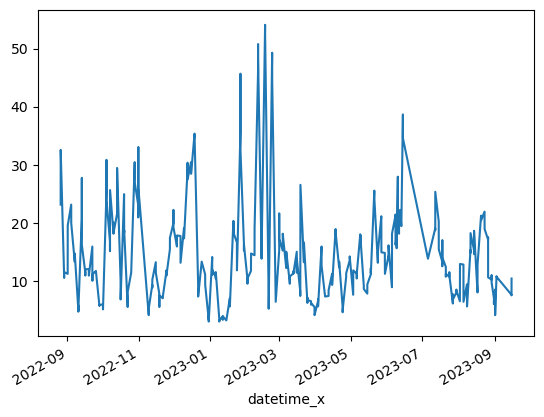

In [12]:
emissions = df['PM10']
emissions.plot()

In [13]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [14]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(emissions, WINDOW_SIZE)
X1.shape, y1.shape

((5827, 5, 1), (5827,))

In [15]:
X_train1, y_train1 = X1[:4000], y1[:4000]
X_val1, y_val1 = X1[4000:4800], y1[4000:4800]
X_test1, y_test1 = X1[4800:], y1[4800:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((4000, 5, 1), (4000,), (800, 5, 1), (800,), (1027, 5, 1), (1027,))

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [19]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [20]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
121/125 [============================>.] - ETA: 0s - loss: 256.1839 - root_mean_squared_error: 16.0057

125/125 [==============================] - 22s 141ms/step - loss: 254.6886 - root_mean_squared_error: 15.9590 - val_loss: 238.3633 - val_root_mean_squared_error: 15.4390
Epoch 2/10
116/125 [==========================>...] - ETA: 0s - loss: 196.2001 - root_mean_squared_error: 14.0071

125/125 [==============================] - 13s 105ms/step - loss: 193.2422 - root_mean_squared_error: 13.9012 - val_loss: 172.1383 - val_root_mean_squared_error: 13.1201
Epoch 3/10
116/125 [==========================>...] - ETA: 0s - loss: 135.1630 - root_mean_squared_error: 11.6260

125/125 [==============================] - 15s 124ms/step - loss: 134.1337 - root_mean_squared_error: 11.5816 - val_loss: 122.2984 - val_root_mean_squared_error: 11.0589
Epoch 4/10
124/125 [============================>.] - ETA: 0s - loss: 100.8133 - root_mean_squared_error: 10.0406

125/125 [==============================] - 18s 143ms/step - loss: 100.7765 - root_mean_squared_error: 10.0388 - val_loss: 99.8970 - val_root_mean_squared_error: 9.9948
Epoch 5/10
124/125 [============================>.] - ETA: 0s - loss: 86.5703 - root_mean_squared_error: 9.3043

125/125 [==============================] - 16s 126ms/step - loss: 86.8760 - root_mean_squared_error: 9.3207 - val_loss: 89.6850 - val_root_mean_squared_error: 9.4702
Epoch 6/10
124/125 [============================>.] - ETA: 0s - loss: 79.9897 - root_mean_squared_error: 8.9437

125/125 [==============================] - 20s 163ms/step - loss: 79.5814 - root_mean_squared_error: 8.9208 - val_loss: 82.6067 - val_root_mean_squared_error: 9.0888
Epoch 7/10
119/125 [===========================>..] - ETA: 0s - loss: 74.5821 - root_mean_squared_error: 8.6361

125/125 [==============================] - 17s 133ms/step - loss: 73.6681 - root_mean_squared_error: 8.5830 - val_loss: 75.9647 - val_root_mean_squared_error: 8.7158
Epoch 8/10
122/125 [============================>.] - ETA: 0s - loss: 68.3043 - root_mean_squared_error: 8.2646

125/125 [==============================] - 17s 138ms/step - loss: 67.8886 - root_mean_squared_error: 8.2395 - val_loss: 70.3923 - val_root_mean_squared_error: 8.3900
Epoch 9/10
122/125 [============================>.] - ETA: 0s - loss: 62.4827 - root_mean_squared_error: 7.9046

125/125 [==============================] - 17s 140ms/step - loss: 62.7549 - root_mean_squared_error: 7.9218 - val_loss: 64.8969 - val_root_mean_squared_error: 8.0559
Epoch 10/10
118/125 [===========================>..] - ETA: 0s - loss: 59.1280 - root_mean_squared_error: 7.6895

125/125 [==============================] - 22s 176ms/step - loss: 58.7959 - root_mean_squared_error: 7.6678 - val_loss: 61.1792 - val_root_mean_squared_error: 7.8217


In [21]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [22]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

125/125 [==============================] - 2s 6ms/step


,Train Predictions,Actuals
0,13.622010,11.6
1,12.852242,11.3
2,12.448582,14.6
3,14.167357,19.6
4,16.603041,23.2
...,...,...
3995,16.614370,17.7
3996,16.728550,17.9
3997,16.839226,17.8
3998,16.841763,13.4


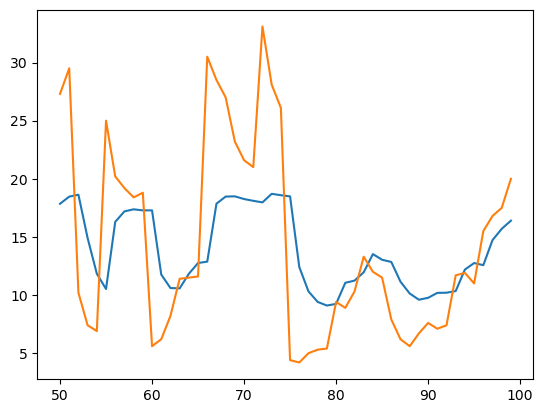

In [23]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [24]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

25/25 [==============================] - 0s 8ms/step


,Val Predictions,Actuals
0,14.263607,19.2
1,16.511623,17.4
2,16.495144,17.5
3,16.678539,29.1
4,18.428648,30.4
...,...,...
795,16.460543,16.3
796,16.187681,10.4
797,13.122576,9.6
798,12.028946,10.5


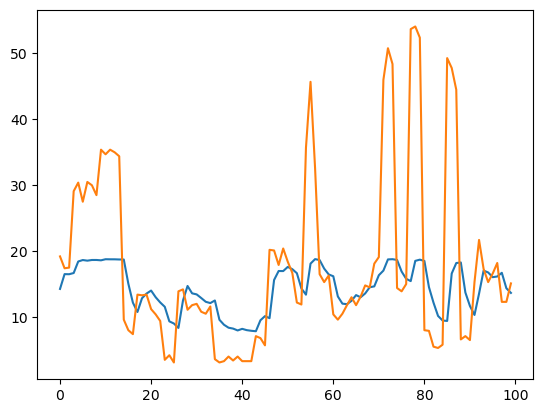

In [25]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [26]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

33/33 [==============================] - 1s 4ms/step


,Test Predictions,Actuals
0,12.458536,13.0
1,13.327362,11.8
2,12.998719,13.1
3,13.579942,14.8
4,14.517666,14.5
...,...,...
1022,11.349430,10.9
1023,11.990904,10.8
1024,12.349892,7.7
1025,11.161692,7.6


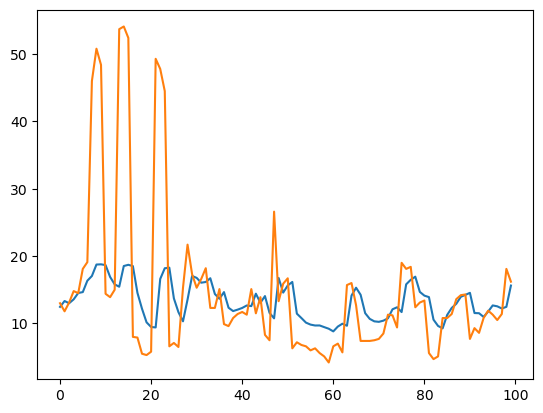

In [27]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

## Convolutional Neural Network

In [28]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [29]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [30]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])

Epoch 1/10
117/125 [===========================>..] - ETA: 0s - loss: 189.3554 - root_mean_squared_error: 13.7606

125/125 [==============================] - 5s 34ms/step - loss: 183.3951 - root_mean_squared_error: 13.5423 - val_loss: 91.6827 - val_root_mean_squared_error: 9.5751
Epoch 2/10
121/125 [============================>.] - ETA: 0s - loss: 75.1201 - root_mean_squared_error: 8.6672

125/125 [==============================] - 2s 17ms/step - loss: 74.9463 - root_mean_squared_error: 8.6572 - val_loss: 68.0379 - val_root_mean_squared_error: 8.2485
Epoch 3/10
118/125 [===========================>..] - ETA: 0s - loss: 59.0765 - root_mean_squared_error: 7.6861

125/125 [==============================] - 3s 24ms/step - loss: 59.4301 - root_mean_squared_error: 7.7091 - val_loss: 56.2023 - val_root_mean_squared_error: 7.4968
Epoch 4/10
125/125 [==============================] - ETA: 0s - loss: 50.3884 - root_mean_squared_error: 7.0985

125/125 [==============================] - 3s 21ms/step - loss: 50.3884 - root_mean_squared_error: 7.0985 - val_loss: 49.1613 - val_root_mean_squared_error: 7.0115
Epoch 5/10
125/125 [==============================] - ETA: 0s - loss: 44.9420 - root_mean_squared_error: 6.7039

125/125 [==============================] - 3s 26ms/step - loss: 44.9420 - root_mean_squared_error: 6.7039 - val_loss: 45.0698 - val_root_mean_squared_error: 6.7134
Epoch 6/10
107/125 [========================>.....] - ETA: 0s - loss: 41.5436 - root_mean_squared_error: 6.4454

125/125 [==============================] - 3s 24ms/step - loss: 41.7826 - root_mean_squared_error: 6.4639 - val_loss: 43.0783 - val_root_mean_squared_error: 6.5634
Epoch 7/10
124/125 [============================>.] - ETA: 0s - loss: 40.0119 - root_mean_squared_error: 6.3255

125/125 [==============================] - 3s 24ms/step - loss: 40.0868 - root_mean_squared_error: 6.3314 - val_loss: 41.3868 - val_root_mean_squared_error: 6.4333
Epoch 8/10
111/125 [=========================>....] - ETA: 0s - loss: 37.5211 - root_mean_squared_error: 6.1254

125/125 [==============================] - 3s 20ms/step - loss: 39.0336 - root_mean_squared_error: 6.2477 - val_loss: 40.5175 - val_root_mean_squared_error: 6.3653
Epoch 9/10
114/125 [==========================>...] - ETA: 0s - loss: 39.0350 - root_mean_squared_error: 6.2478

125/125 [==============================] - 3s 26ms/step - loss: 38.3272 - root_mean_squared_error: 6.1909 - val_loss: 39.9356 - val_root_mean_squared_error: 6.3195
Epoch 10/10
122/125 [============================>.] - ETA: 0s - loss: 38.2703 - root_mean_squared_error: 6.1863

125/125 [==============================] - 3s 21ms/step - loss: 37.9420 - root_mean_squared_error: 6.1597 - val_loss: 39.5050 - val_root_mean_squared_error: 6.2853


## GRU (Gated Recurrent Unit)

In [31]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [32]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [33]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp3])

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 281.2291 - root_mean_squared_error: 16.7699

125/125 [==============================] - 18s 118ms/step - loss: 281.2291 - root_mean_squared_error: 16.7699 - val_loss: 264.4203 - val_root_mean_squared_error: 16.2610
Epoch 2/10
122/125 [============================>.] - ETA: 0s - loss: 227.0378 - root_mean_squared_error: 15.0678

125/125 [==============================] - 12s 100ms/step - loss: 226.7217 - root_mean_squared_error: 15.0573 - val_loss: 214.4881 - val_root_mean_squared_error: 14.6454
Epoch 3/10
113/125 [==========================>...] - ETA: 0s - loss: 163.7390 - root_mean_squared_error: 12.7961

125/125 [==============================] - 11s 91ms/step - loss: 160.4006 - root_mean_squared_error: 12.6649 - val_loss: 140.1203 - val_root_mean_squared_error: 11.8372
Epoch 4/10
119/125 [===========================>..] - ETA: 0s - loss: 113.9864 - root_mean_squared_error: 10.6764

125/125 [==============================] - 11s 91ms/step - loss: 112.5770 - root_mean_squared_error: 10.6102 - val_loss: 108.2469 - val_root_mean_squared_error: 10.4042
Epoch 5/10
123/125 [============================>.] - ETA: 0s - loss: 90.7656 - root_mean_squared_error: 9.5271

125/125 [==============================] - 11s 92ms/step - loss: 90.7137 - root_mean_squared_error: 9.5244 - val_loss: 90.7175 - val_root_mean_squared_error: 9.5246
Epoch 6/10
117/125 [===========================>..] - ETA: 0s - loss: 78.6619 - root_mean_squared_error: 8.8692

125/125 [==============================] - 12s 95ms/step - loss: 77.6429 - root_mean_squared_error: 8.8115 - val_loss: 78.6238 - val_root_mean_squared_error: 8.8670
Epoch 7/10
123/125 [============================>.] - ETA: 0s - loss: 68.1311 - root_mean_squared_error: 8.2542

125/125 [==============================] - 13s 102ms/step - loss: 68.6744 - root_mean_squared_error: 8.2870 - val_loss: 70.5856 - val_root_mean_squared_error: 8.4015
Epoch 8/10
125/125 [==============================] - ETA: 0s - loss: 62.6466 - root_mean_squared_error: 7.9150

125/125 [==============================] - 13s 102ms/step - loss: 62.6466 - root_mean_squared_error: 7.9150 - val_loss: 65.0731 - val_root_mean_squared_error: 8.0668
Epoch 9/10
122/125 [============================>.] - ETA: 0s - loss: 58.8106 - root_mean_squared_error: 7.6688

125/125 [==============================] - 12s 96ms/step - loss: 58.4406 - root_mean_squared_error: 7.6446 - val_loss: 60.7980 - val_root_mean_squared_error: 7.7973
Epoch 10/10
111/125 [=========================>....] - ETA: 0s - loss: 54.2419 - root_mean_squared_error: 7.3649

125/125 [==============================] - 12s 95ms/step - loss: 54.9930 - root_mean_squared_error: 7.4157 - val_loss: 57.2446 - val_root_mean_squared_error: 7.5660


# Multivariate Time Series Forecasting (LSTM)

## Preprocessing

In [166]:
multi_df = pred_data.copy()
multi_df['Seconds'] = multi_df.index.map(pd.Timestamp.timestamp)
multi_df

,Bezeichnung,D1Z,D2Z,D3Z,D4Z,D5Z,D6Z,D7Z,D8Z,D9Z,...,D63Z,D64Z,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],datetime_x,PM10,Seconds
datetime_x,,,,,,,,,,,,,,,,,,,,,
2022-08-26 07:00:00,A1,8.0,13.0,89.0,105.0,38.0,11.0,22.0,22.0,62.0,...,0.0,0.0,1012.0,78.8,20.2,0.5,70.0,2022-08-26 07:00:00,23.2,1.661497e+09
2022-08-26 07:30:00,A1,27.0,28.0,196.0,223.0,81.0,26.0,53.0,73.0,114.0,...,0.0,0.0,1012.0,77.9,20.4,0.4,55.0,2022-08-26 07:30:00,28.0,1.661499e+09
2022-08-26 08:00:00,A1,9.0,17.0,124.0,131.0,53.0,14.0,38.0,55.0,88.0,...,0.0,0.0,1012.0,75.1,21.2,0.6,35.0,2022-08-26 08:00:00,32.6,1.661501e+09
2022-08-29 07:00:00,A1,14.0,13.0,115.0,119.0,48.0,7.0,28.0,37.0,56.0,...,0.0,0.0,1019.0,79.4,13.0,1.2,40.0,2022-08-29 07:00:00,10.6,1.661756e+09
2022-08-29 07:30:00,A1,31.0,28.0,250.0,257.0,81.0,24.0,48.0,55.0,151.0,...,0.0,0.0,1019.0,76.7,13.9,1.2,43.0,2022-08-29 07:30:00,11.3,1.661758e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-02 04:00:00,A90,6.0,4.0,2.0,8.0,30.0,4.0,2.0,0.0,4.0,...,0.0,0.0,1016.0,96.6,12.7,NaN,NaN,2023-09-02 04:00:00,10.9,1.693627e+09
2023-09-02 04:30:00,A90,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1017.0,96.6,12.6,NaN,NaN,2023-09-02 04:30:00,10.8,1.693629e+09
2023-09-14 23:00:00,A90,1.0,6.0,1.0,11.0,22.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1019.0,94.6,11.0,NaN,NaN,2023-09-14 23:00:00,7.7,1.694732e+09


In [167]:
day = 60*60*24
year = 365.2425*day

multi_df['Day sin'] = np.sin(multi_df['Seconds'] * (2* np.pi / day))
multi_df['Day cos'] = np.cos(multi_df['Seconds'] * (2 * np.pi / day))
multi_df['Year sin'] = np.sin(multi_df['Seconds'] * (2 * np.pi / year))
multi_df['Year cos'] = np.cos(multi_df['Seconds'] * (2 * np.pi / year))
multi_df.head()


,Bezeichnung,D1Z,D2Z,D3Z,D4Z,D5Z,D6Z,D7Z,D8Z,D9Z,...,Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],datetime_x,PM10,Seconds,Day sin,Day cos,Year sin,Year cos
datetime_x,,,,,,,,,,,,,,,,,,,,,
2022-08-26 07:00:00,A1,8.0,13.0,89.0,105.0,38.0,11.0,22.0,22.0,62.0,...,20.2,0.5,70.0,2022-08-26 07:00:00,23.2,1.661497e+09,0.965926,-0.258819,-0.811779,-0.583965
2022-08-26 07:30:00,A1,27.0,28.0,196.0,223.0,81.0,26.0,53.0,73.0,114.0,...,20.4,0.4,55.0,2022-08-26 07:30:00,28.0,1.661499e+09,0.923880,-0.382683,-0.811988,-0.583674
2022-08-26 08:00:00,A1,9.0,17.0,124.0,131.0,53.0,14.0,38.0,55.0,88.0,...,21.2,0.6,35.0,2022-08-26 08:00:00,32.6,1.661501e+09,0.866025,-0.500000,-0.812197,-0.583383
2022-08-29 07:00:00,A1,14.0,13.0,115.0,119.0,48.0,7.0,28.0,37.0,56.0,...,13.0,1.2,40.0,2022-08-29 07:00:00,10.6,1.661756e+09,0.965926,-0.258819,-0.840822,-0.541311
2022-08-29 07:30:00,A1,31.0,28.0,250.0,257.0,81.0,24.0,48.0,55.0,151.0,...,13.9,1.2,43.0,2022-08-29 07:30:00,11.3,1.661758e+09,0.923880,-0.382683,-0.841016,-0.541010


In [168]:
#move target to be first column
column_to_move = multi_df.pop('PM10')
multi_df.insert(0, 'PM10', column_to_move)
multi_df

,PM10,Bezeichnung,D1Z,D2Z,D3Z,D4Z,D5Z,D6Z,D7Z,D8Z,...,Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],datetime_x,Seconds,Day sin,Day cos,Year sin,Year cos
datetime_x,,,,,,,,,,,,,,,,,,,,,
2022-08-26 07:00:00,23.2,A1,8.0,13.0,89.0,105.0,38.0,11.0,22.0,22.0,...,78.8,20.2,0.5,70.0,2022-08-26 07:00:00,1.661497e+09,9.659258e-01,-0.258819,-0.811779,-0.583965
2022-08-26 07:30:00,28.0,A1,27.0,28.0,196.0,223.0,81.0,26.0,53.0,73.0,...,77.9,20.4,0.4,55.0,2022-08-26 07:30:00,1.661499e+09,9.238795e-01,-0.382683,-0.811988,-0.583674
2022-08-26 08:00:00,32.6,A1,9.0,17.0,124.0,131.0,53.0,14.0,38.0,55.0,...,75.1,21.2,0.6,35.0,2022-08-26 08:00:00,1.661501e+09,8.660254e-01,-0.500000,-0.812197,-0.583383
2022-08-29 07:00:00,10.6,A1,14.0,13.0,115.0,119.0,48.0,7.0,28.0,37.0,...,79.4,13.0,1.2,40.0,2022-08-29 07:00:00,1.661756e+09,9.659258e-01,-0.258819,-0.840822,-0.541311
2022-08-29 07:30:00,11.3,A1,31.0,28.0,250.0,257.0,81.0,24.0,48.0,55.0,...,76.7,13.9,1.2,43.0,2022-08-29 07:30:00,1.661758e+09,9.238795e-01,-0.382683,-0.841016,-0.541010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-02 04:00:00,10.9,A90,6.0,4.0,2.0,8.0,30.0,4.0,2.0,0.0,...,96.6,12.7,NaN,NaN,2023-09-02 04:00:00,1.693627e+09,8.660254e-01,0.500000,-0.872985,-0.487747
2023-09-02 04:30:00,10.8,A90,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,...,96.6,12.6,NaN,NaN,2023-09-02 04:30:00,1.693629e+09,9.238795e-01,0.382683,-0.873160,-0.487434
2023-09-14 23:00:00,7.7,A90,1.0,6.0,1.0,11.0,22.0,0.0,0.0,0.0,...,94.6,11.0,NaN,NaN,2023-09-14 23:00:00,1.694732e+09,-2.588190e-01,0.965926,-0.958400,-0.285430


In [169]:
#drop unwanted columns
multi_df = multi_df.drop(columns = ['datetime_x', 'Seconds', 'Bezeichnung'])

In [212]:
multi_df = multi_df.fillna(multi_df.mean())

In [213]:
multi_df

,PM10,D1Z,D2Z,D3Z,D4Z,D5Z,D6Z,D7Z,D8Z,D9Z,...,D64Z,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],Day sin,Day cos,Year sin,Year cos
datetime_x,,,,,,,,,,,,,,,,,,,,,
2022-08-26 07:00:00,23.2,8.0,13.0,89.0,105.0,38.0,11.0,22.0,22.0,62.0,...,0.0,1012.0,78.8,20.2,0.500000,70.000000,9.659258e-01,-0.258819,-0.811779,-0.583965
2022-08-26 07:30:00,28.0,27.0,28.0,196.0,223.0,81.0,26.0,53.0,73.0,114.0,...,0.0,1012.0,77.9,20.4,0.400000,55.000000,9.238795e-01,-0.382683,-0.811988,-0.583674
2022-08-26 08:00:00,32.6,9.0,17.0,124.0,131.0,53.0,14.0,38.0,55.0,88.0,...,0.0,1012.0,75.1,21.2,0.600000,35.000000,8.660254e-01,-0.500000,-0.812197,-0.583383
2022-08-29 07:00:00,10.6,14.0,13.0,115.0,119.0,48.0,7.0,28.0,37.0,56.0,...,0.0,1019.0,79.4,13.0,1.200000,40.000000,9.659258e-01,-0.258819,-0.840822,-0.541311
2022-08-29 07:30:00,11.3,31.0,28.0,250.0,257.0,81.0,24.0,48.0,55.0,151.0,...,0.0,1019.0,76.7,13.9,1.200000,43.000000,9.238795e-01,-0.382683,-0.841016,-0.541010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-02 04:00:00,10.9,6.0,4.0,2.0,8.0,30.0,4.0,2.0,0.0,4.0,...,0.0,1016.0,96.6,12.7,1.029168,137.837205,8.660254e-01,0.500000,-0.872985,-0.487747
2023-09-02 04:30:00,10.8,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,...,0.0,1017.0,96.6,12.6,1.029168,137.837205,9.238795e-01,0.382683,-0.873160,-0.487434
2023-09-14 23:00:00,7.7,1.0,6.0,1.0,11.0,22.0,0.0,0.0,0.0,0.0,...,0.0,1019.0,94.6,11.0,1.029168,137.837205,-2.588190e-01,0.965926,-0.958400,-0.285430


In [214]:
multi_df.describe()

,PM10,D1Z,D2Z,D3Z,D4Z,D5Z,D6Z,D7Z,D8Z,D9Z,...,D64Z,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],Day sin,Day cos,Year sin,Year cos
count,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,...,5832.0,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5.832000e+03,5832.000000,5832.000000,5832.000000
mean,14.972634,52.732853,36.282407,47.338992,39.694444,34.271948,22.986626,30.895919,48.190844,33.505316,...,0.0,1015.297154,74.940724,11.149280,1.029168,137.837205,-2.732608e-01,0.010720,-0.029945,0.040462
std,9.071156,113.455532,29.690347,53.650426,48.672629,42.862666,23.589894,46.892412,242.214178,43.487331,...,0.0,8.128660,15.594675,5.816526,0.516061,83.965256,5.655471e-01,0.778157,0.726438,0.685511
min,3.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,985.000000,31.100000,-4.900000,0.400000,3.000000,-1.000000e+00,-1.000000,-0.999998,-0.998492
25%,8.700000,15.000000,16.000000,11.000000,9.000000,3.000000,7.000000,5.000000,3.000000,1.000000,...,0.0,1011.000000,63.700000,7.300000,0.600000,56.000000,-7.071068e-01,-0.793353,-0.784372,-0.591261
50%,12.900000,32.000000,30.000000,31.000000,25.000000,22.000000,17.000000,18.000000,22.000000,19.000000,...,0.0,1015.000000,75.900000,11.400000,1.000000,137.837205,-3.826834e-01,-0.130526,-0.073018,0.048718
75%,18.400000,64.000000,50.000000,65.000000,52.000000,50.000000,31.000000,42.000000,51.000000,49.000000,...,0.0,1020.000000,88.000000,15.300000,1.300000,227.000000,4.785941e-12,0.866025,0.685143,0.734070
max,54.100000,3036.000000,255.000000,626.000000,600.000000,776.000000,276.000000,1182.000000,13262.000000,432.000000,...,0.0,1037.000000,98.900000,24.300000,2.900000,345.000000,9.659258e-01,1.000000,0.999925,0.999777


In [156]:
#standardize

scaler = MinMaxScaler(feature_range=(-1, 1))

multi_df_scaled = scaler.fit_transform(multi_df)
multi_df = pd.DataFrame(multi_df_scaled, columns=multi_df.columns, index=multi_df.index)


In [157]:
multi_df

,PM10,D1Z,D2Z,D3Z,D4Z,D5Z,D6Z,D7Z,D8Z,D9Z,...,D64Z,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],Day sin,Day cos,Year sin,Year cos
datetime_x,,,,,,,,,,,,,,,,,,,,,
2022-08-26 07:00:00,-0.211765,-0.994730,-0.898039,-0.715655,-0.650000,-0.902062,-0.920290,-0.962775,-0.996682,-0.712963,...,-1.0,0.038462,0.407080,0.719178,-0.92,-0.608187,1.000000,-0.258819,-0.811774,-0.585114
2022-08-26 07:30:00,-0.023529,-0.982213,-0.780392,-0.373802,-0.256667,-0.791237,-0.811594,-0.910321,-0.988991,-0.472222,...,-1.0,0.038462,0.380531,0.732877,-1.00,-0.695906,0.957225,-0.382683,-0.811983,-0.584823
2022-08-26 08:00:00,0.156863,-0.994071,-0.866667,-0.603834,-0.563333,-0.863402,-0.898551,-0.935702,-0.991706,-0.592593,...,-1.0,0.038462,0.297935,0.787671,-0.84,-0.812865,0.898368,-0.500000,-0.812192,-0.584531
2022-08-29 07:00:00,-0.705882,-0.990777,-0.898039,-0.632588,-0.603333,-0.876289,-0.949275,-0.952623,-0.994420,-0.740741,...,-1.0,0.307692,0.424779,0.226027,-0.36,-0.783626,1.000000,-0.258819,-0.840818,-0.542423
2022-08-29 07:30:00,-0.678431,-0.979578,-0.780392,-0.201278,-0.143333,-0.791237,-0.826087,-0.918782,-0.991706,-0.300926,...,-1.0,0.307692,0.345133,0.287671,-0.36,-0.766082,0.957225,-0.382683,-0.841012,-0.542122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-02 04:00:00,-0.694118,-0.996047,-0.968627,-0.993610,-0.973333,-0.922680,-0.971014,-0.996616,-1.000000,-0.981481,...,-1.0,0.192308,0.932153,0.205479,NaN,NaN,0.898368,0.500000,-0.872983,-0.488812
2023-09-02 04:30:00,-0.698039,-1.000000,-1.000000,-1.000000,-1.000000,-0.958763,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,0.230769,0.932153,0.198630,NaN,NaN,0.957225,0.382683,-0.873157,-0.488499
2023-09-14 23:00:00,-0.819608,-0.999341,-0.952941,-0.996805,-0.963333,-0.943299,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,0.307692,0.873156,0.089041,NaN,NaN,-0.245973,0.965926,-0.958400,-0.286320


## create tensors

In [215]:
def df_to_X_y2(df, window_size=250):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    #define y
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [216]:
X2, y2 = df_to_X_y2(multi_df)
X2.shape, y2.shape

((5582, 250, 74), (5582,))

In [217]:
#split data
X2_train, y2_train = X2[:4000], y2[:4000]
X2_val, y2_val = X2[4000:4800], y2[4000:4800]
X2_test, y2_test = X2[4800:], y2[4800:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape


((4000, 250, 74), (4000,), (800, 250, 74), (800,), (782, 250, 74), (782,))

# create model & predict

In [202]:
#create model
from tensorflow.keras.backend import clear_session

clear_session()

model4 = Sequential()
model4.add(InputLayer((250, 74)))
model4.add(LSTM(165))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 165)               158400    
                                                                 
 dense (Dense)               (None, 8)                 1328      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 159,737
Trainable params: 159,737
Non-trainable params: 0
_________________________________________________________________


In [207]:
from tensorflow.keras.metrics import MeanAbsoluteError

#set up checkpoint to save best model
cp4 = ModelCheckpoint('model4/', save_best_only=True)
#compile model 
model4.compile(loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [218]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.backend import clear_session

# Clear the Keras session
clear_session()

# Set up checkpoint to save the best model
cp4 = ModelCheckpoint('model4/', save_best_only=True)

# Create the model
model4 = Sequential()

# Input layer
model4.add(InputLayer((250, 74)))

model4.add(LSTM(256, return_sequences=True))
model4.add(Dropout(0.2))

# Decrease the number of neurons in Dense layers and add L1-Regularization
model4.add(Dense(64, activation='relu', kernel_regularizer=l1(0.001)))
model4.add(Dense(16, activation='relu', kernel_regularizer=l1(0.001)))


model4.add(Dense(1, activation='linear'))

model4.compile(loss='mean_absolute_error', optimizer=Adagrad(learning_rate=1), metrics=[RootMeanSquaredError()])

# Display model summary
model4.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250, 256)          338944    
                                                                 
 dropout (Dropout)           (None, 250, 256)          0         
                                                                 
 dense (Dense)               (None, 250, 64)           16448     
                                                                 
 dense_1 (Dense)             (None, 250, 16)           1040      
                                                                 
 dense_2 (Dense)             (None, 250, 1)            17        
                                                                 
Total params: 356,449
Trainable params: 356,449
Non-trainable params: 0
_________________________________________________________________


In [219]:
#fit model
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp4])

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 17.8302 - root_mean_squared_error: 83.1610

125/125 [==============================] - 76s 564ms/step - loss: 17.8302 - root_mean_squared_error: 83.1610 - val_loss: 8.3382 - val_root_mean_squared_error: 9.3418
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 8.0327 - root_mean_squared_error: 9.2577

125/125 [==============================] - 74s 596ms/step - loss: 8.0327 - root_mean_squared_error: 9.2577 - val_loss: 7.9461 - val_root_mean_squared_error: 9.3137
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 7.7285 - root_mean_squared_error: 9.2647

125/125 [==============================] - 104s 836ms/step - loss: 7.7285 - root_mean_squared_error: 9.2647 - val_loss: 7.7178 - val_root_mean_squared_error: 9.2635
Epoch 4/10
125/125 [==============================] - ETA: 0s - loss: 7.5365 - root_mean_squared_error: 9.2436

125/125 [==============================] - 126s 1s/step - loss: 7.5365 - root_mean_squared_error: 9.2436 - val_loss: 7.5442 - val_root_mean_squared_error: 9.2770
Epoch 5/10
125/125 [==============================] - ETA: 0s - loss: 7.3701 - root_mean_squared_error: 9.2122

125/125 [==============================] - 129s 1s/step - loss: 7.3701 - root_mean_squared_error: 9.2122 - val_loss: 7.4208 - val_root_mean_squared_error: 9.5125
Epoch 6/10
125/125 [==============================] - ETA: 0s - loss: 7.2449 - root_mean_squared_error: 9.2738

125/125 [==============================] - 111s 890ms/step - loss: 7.2449 - root_mean_squared_error: 9.2738 - val_loss: 7.2776 - val_root_mean_squared_error: 9.3958
Epoch 7/10
125/125 [==============================] - ETA: 0s - loss: 7.1264 - root_mean_squared_error: 9.2569

125/125 [==============================] - 91s 733ms/step - loss: 7.1264 - root_mean_squared_error: 9.2569 - val_loss: 7.1652 - val_root_mean_squared_error: 9.3063
Epoch 8/10
125/125 [==============================] - ETA: 0s - loss: 7.0276 - root_mean_squared_error: 9.2303

125/125 [==============================] - 215s 2s/step - loss: 7.0276 - root_mean_squared_error: 9.2303 - val_loss: 7.0787 - val_root_mean_squared_error: 9.3842
Epoch 9/10
125/125 [==============================] - ETA: 0s - loss: 6.9435 - root_mean_squared_error: 9.2779

125/125 [==============================] - 134s 1s/step - loss: 6.9435 - root_mean_squared_error: 9.2779 - val_loss: 7.0014 - val_root_mean_squared_error: 9.2730
Epoch 10/10
125/125 [==============================] - ETA: 0s - loss: 6.8754 - root_mean_squared_error: 9.2301

125/125 [==============================] - 99s 792ms/step - loss: 6.8754 - root_mean_squared_error: 9.2301 - val_loss: 6.9423 - val_root_mean_squared_error: 9.3863


In [220]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

In [225]:
predictions = model4.predict(X2_test).flatten()
df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y2_test})
df

25/25 [==============================] - 3s 118ms/step


array([12.559116, 12.559116, 12.559116, ..., 12.559116, 12.559116,
       12.559116], dtype=float32)

In [221]:
plot_predictions1(model4, X2_test, y2_test)

25/25 [==============================] - 8s 260ms/step


ValueError: All arrays must be of the same length

25/25 [==============================] - 3s 95ms/step


(     Predictions  Actuals
 0       0.124199     16.3
 1       0.124199     11.5
 2       0.124199     11.0
 3       0.124199     12.1
 4       0.124199     12.1
 ..           ...      ...
 777     0.124199     10.9
 778     0.124199     10.8
 779     0.124199      7.7
 780     0.124199      7.6
 781     0.124199     10.5
 
 [782 rows x 2 columns],
 299.74972576195916)

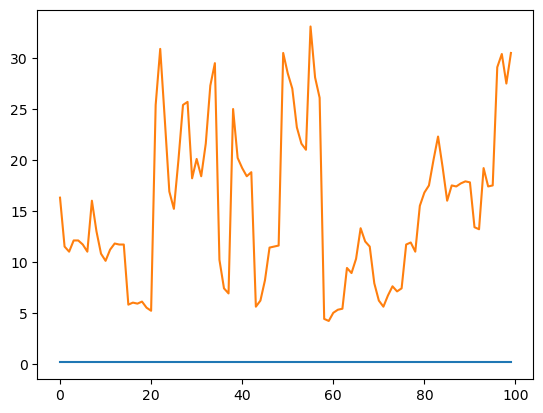

In [205]:
plot_predictions1(model4, X2_test, y2_test)

# Neural Network with just one column for traffic

In [23]:
traffic = pd.read_csv('traffic.csv')

In [24]:
traffic_gr= traffic.groupby(['roundedTimestamp', 'Bezeichnung']).sum()
traffic_gr = traffic_gr.reset_index()
traffic_gr

,roundedTimestamp,Bezeichnung,D1Z,D2Z,D3Z,D4Z,D5Z,D6Z,D7Z,D8Z,...,D55Z,D56Z,D57Z,D58Z,D59Z,D60Z,D61Z,D62Z,D63Z,D64Z
0,2022-08-26 07:00:00,A1,8.0,13.0,89.0,105.0,38.0,11.0,22.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-08-26 07:00:00,A10,45.0,41.0,21.0,3.0,44.0,23.0,36.0,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-08-26 07:00:00,A11,0.0,0.0,4.0,42.0,48.0,27.0,5.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-08-26 07:00:00,A111,27.0,24.0,35.0,4.0,3.0,3.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-08-26 07:00:00,A126,11.0,11.0,31.0,22.0,30.0,21.0,16.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5827,2023-09-15 00:00:00,A33,5.0,8.0,13.0,10.0,0.0,12.0,11.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5828,2023-09-15 00:00:00,A36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5829,2023-09-15 00:00:00,A69,11.0,10.0,9.0,10.0,0.0,5.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5830,2023-09-15 00:00:00,A8,7.0,4.0,5.0,18.0,21.0,16.0,7.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
sum_vehicles_list = []

for i, row in traffic_gr.iterrows():
    sum_vehicles = row[2:67].sum()
    sum_vehicles_list.append(sum_vehicles)

traffic_gr['SumVehicles'] = sum_vehicles_list

In [26]:
data = {'intersection' : traffic_gr['Bezeichnung'], 'timestamp' : traffic_gr['roundedTimestamp'], 'sum_vehicles': sum_vehicles_list}
traffic_sum = pd.DataFrame(data = data)
traffic_sum

,intersection,timestamp,sum_vehicles
0,A1,2022-08-26 07:00:00,521.0
1,A10,2022-08-26 07:00:00,313.0
2,A11,2022-08-26 07:00:00,159.0
3,A111,2022-08-26 07:00:00,100.0
4,A126,2022-08-26 07:00:00,272.0
...,...,...,...
5827,A33,2023-09-15 00:00:00,138.0
5828,A36,2023-09-15 00:00:00,66.0
5829,A69,2023-09-15 00:00:00,138.0
5830,A8,2023-09-15 00:00:00,228.0


In [27]:
traffic_sum_total = traffic_sum.groupby('timestamp')['sum_vehicles'].sum()
traffic_sum_total = pd.DataFrame(traffic_sum_total).reset_index()
traffic_sum_total

,timestamp,sum_vehicles
0,2022-08-26 07:00:00,5954.0
1,2022-08-26 07:30:00,15142.0
2,2022-08-26 08:00:00,9244.0
3,2022-08-29 07:00:00,6946.0
4,2022-08-29 07:30:00,15945.0
...,...,...
403,2023-09-02 04:00:00,16310.0
404,2023-09-02 04:30:00,3500.0
405,2023-09-14 23:00:00,4147.0
406,2023-09-14 23:30:00,9312.0


In [28]:
pred_data1 = traffic_sum_total.merge(weather, how='left', left_on= 'timestamp', right_on='datetime').merge(emissions[['PM10', 'PM2,5', 'NO2', 'datetime']], how='left', left_on= 'timestamp', right_on='datetime' )
pred_data1.drop(columns=['datetime_y', 'datetime_x'], inplace = True)
show(pred_data1)

df_sum = pred_data1.copy()

In [ ]:
df_sum.index = pd.to_datetime(df_sum['timestamp'], format='%Y-%m-%d %H:%M:%S')
df_sum[:26]

In [ ]:
df_sum['Seconds'] = df_sum.index.map(pd.Timestamp.timestamp)
df_sum

In [31]:
day = 60*60*24
year = 365.2425*day

df_sum['Day sin'] = np.sin(df_sum['Seconds'] * (2* np.pi / day))
df_sum['Day cos'] = np.cos(df_sum['Seconds'] * (2 * np.pi / day))
df_sum['Year sin'] = np.sin(df_sum['Seconds'] * (2 * np.pi / year))
df_sum['Year cos'] = np.cos(df_sum['Seconds'] * (2 * np.pi / year))
df_sum.head()


,timestamp,sum_vehicles,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],PM10,"PM2,5",NO2,Seconds,Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,,,,,
2022-08-26 07:00:00,2022-08-26 07:00:00,5954.0,1012.0,78.8,20.2,0.5,70.0,23.2,12.8,33.5,1.661497e+09,0.965926,-0.258819,-0.811779,-0.583965
2022-08-26 07:30:00,2022-08-26 07:30:00,15142.0,1012.0,77.9,20.4,0.4,55.0,28.0,13.8,43.7,1.661499e+09,0.923880,-0.382683,-0.811988,-0.583674
2022-08-26 08:00:00,2022-08-26 08:00:00,9244.0,1012.0,75.1,21.2,0.6,35.0,32.6,14.7,39.9,1.661501e+09,0.866025,-0.500000,-0.812197,-0.583383
2022-08-29 07:00:00,2022-08-29 07:00:00,6946.0,1019.0,79.4,13.0,1.2,40.0,10.6,4.5,15.4,1.661756e+09,0.965926,-0.258819,-0.840822,-0.541311
2022-08-29 07:30:00,2022-08-29 07:30:00,15945.0,1019.0,76.7,13.9,1.2,43.0,11.3,4.7,18.9,1.661758e+09,0.923880,-0.382683,-0.841016,-0.541010


In [32]:
#drop unwanted columns
df_sum = df_sum.drop(columns = ['timestamp', 'Seconds'])

In [33]:
df_sum = df_sum.fillna(df_sum.mean())

In [37]:
df_sum

,sum_vehicles,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],PM10,"PM2,5",NO2,Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,,,
2022-08-26 07:00:00,5954.0,1012.0,78.8,20.2,0.50000,70.000000,23.2,12.8,33.5,9.659258e-01,-0.258819,-0.811779,-0.583965
2022-08-26 07:30:00,15142.0,1012.0,77.9,20.4,0.40000,55.000000,28.0,13.8,43.7,9.238795e-01,-0.382683,-0.811988,-0.583674
2022-08-26 08:00:00,9244.0,1012.0,75.1,21.2,0.60000,35.000000,32.6,14.7,39.9,8.660254e-01,-0.500000,-0.812197,-0.583383
2022-08-29 07:00:00,6946.0,1019.0,79.4,13.0,1.20000,40.000000,10.6,4.5,15.4,9.659258e-01,-0.258819,-0.840822,-0.541311
2022-08-29 07:30:00,15945.0,1019.0,76.7,13.9,1.20000,43.000000,11.3,4.7,18.9,9.238795e-01,-0.382683,-0.841016,-0.541010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-02 04:00:00,16310.0,1016.0,96.6,12.7,1.01779,136.962264,10.9,3.5,8.2,8.660254e-01,0.500000,-0.872985,-0.487747
2023-09-02 04:30:00,3500.0,1017.0,96.6,12.6,1.01779,136.962264,10.8,3.5,10.3,9.238795e-01,0.382683,-0.873160,-0.487434
2023-09-14 23:00:00,4147.0,1019.0,94.6,11.0,1.01779,136.962264,7.7,4.4,13.6,-2.588190e-01,0.965926,-0.958400,-0.285430


In [48]:
y_scaled

,PM10,"PM2,5",NO2
timestamp,,,
2022-08-26 07:00:00,0.394118,0.253363,0.407056
2022-08-26 07:30:00,0.488235,0.275785,0.545455
2022-08-26 08:00:00,0.578431,0.295964,0.493894
2022-08-29 07:00:00,0.147059,0.067265,0.161465
2022-08-29 07:30:00,0.160784,0.071749,0.208955
...,...,...,...
2023-09-02 04:00:00,0.152941,0.044843,0.063772
2023-09-02 04:30:00,0.150980,0.044843,0.092266
2023-09-14 23:00:00,0.090196,0.065022,0.137042


In [50]:

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Separate your DataFrame into features and target variable
X = df_sum.drop(columns=["PM10", "PM2,5", "NO2"])

y = df_sum[["PM10", "PM2,5", "NO2"]]

# Scale the features (X) and target (y) separately
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create a new DataFrame with the scaled features and target variable
X_scaled_df = pd.DataFrame(data=X_scaled, columns=X.columns, index=df_sum.index)
y_scaled_df  = pd.DataFrame(data=y_scaled, columns=y.columns, index=df_sum.index)
df_scaled = y_scaled_df.merge(X_scaled_df, left_index=True, right_index=True)
df_scaled


,PM10,"PM2,5",NO2,sum_vehicles,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,,,
2022-08-26 07:00:00,0.394118,0.253363,0.407056,0.152252,0.519231,0.703540,0.859589,0.040000,0.195906,1.000000,0.370590,0.094113,0.207443
2022-08-26 07:30:00,0.488235,0.275785,0.545455,0.416343,0.519231,0.690265,0.866438,0.000000,0.152047,0.978612,0.308658,0.094008,0.207589
2022-08-26 08:00:00,0.578431,0.295964,0.493894,0.246817,0.519231,0.648968,0.893836,0.080000,0.093567,0.949184,0.250000,0.093904,0.207734
2022-08-29 07:00:00,0.147059,0.067265,0.161465,0.180765,0.653846,0.712389,0.613014,0.320000,0.108187,1.000000,0.370590,0.079591,0.228788
2022-08-29 07:30:00,0.160784,0.071749,0.208955,0.439424,0.653846,0.672566,0.643836,0.320000,0.116959,0.978612,0.308658,0.079494,0.228939
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-02 04:00:00,0.152941,0.044843,0.063772,0.449915,0.596154,0.966077,0.602740,0.247116,0.391703,0.949184,0.750000,0.063509,0.255594
2023-09-02 04:30:00,0.150980,0.044843,0.092266,0.081717,0.615385,0.966077,0.599315,0.247116,0.391703,0.978612,0.691342,0.063421,0.255750
2023-09-14 23:00:00,0.090196,0.065022,0.137042,0.100313,0.653846,0.936578,0.544521,0.247116,0.391703,0.377014,0.982963,0.020800,0.356840


In [72]:
#just necessary with one target 


# #move target to be first column
# column_to_move = df_scaled.pop('PM10')
# df_scaled.insert(0, 'PM10', column_to_move)
# df_scaled

,PM10,sum_vehicles,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,
2022-08-26 07:00:00,0.394118,0.152252,0.519231,0.703540,0.859589,0.040000,0.195906,1.000000,0.370590,0.094113,0.207443
2022-08-26 07:30:00,0.488235,0.416343,0.519231,0.690265,0.866438,0.000000,0.152047,0.978612,0.308658,0.094008,0.207589
2022-08-26 08:00:00,0.578431,0.246817,0.519231,0.648968,0.893836,0.080000,0.093567,0.949184,0.250000,0.093904,0.207734
2022-08-29 07:00:00,0.147059,0.180765,0.653846,0.712389,0.613014,0.320000,0.108187,1.000000,0.370590,0.079591,0.228788
2022-08-29 07:30:00,0.160784,0.439424,0.653846,0.672566,0.643836,0.320000,0.116959,0.978612,0.308658,0.079494,0.228939
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-02 04:00:00,0.152941,0.449915,0.596154,0.966077,0.602740,0.247116,0.391703,0.949184,0.750000,0.063509,0.255594
2023-09-02 04:30:00,0.150980,0.081717,0.615385,0.966077,0.599315,0.247116,0.391703,0.978612,0.691342,0.063421,0.255750
2023-09-14 23:00:00,0.090196,0.100313,0.653846,0.936578,0.544521,0.247116,0.391703,0.377014,0.982963,0.020800,0.356840


In [67]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    #define y
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1], df_as_np[i+window_size][2]]
    y.append(label)
  return np.array(X), np.array(y)

In [68]:
X5, y5 = df_to_X_y2(df_scaled)
X5.shape, y5.shape

((402, 6, 13), (402, 3))

In [69]:
#split data
X5_train, y5_train = X5[:300], y5[:300]
X5_val, y5_val = X5[300:350], y5[300:350]
X5_test, y5_test = X5[350:], y5[350:]
X5_train.shape, y5_train.shape, X5_val.shape, y5_val.shape, X5_test.shape, y5_test.shape


((300, 6, 13), (300, 3), (50, 6, 13), (50, 3), (52, 6, 13), (52, 3))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adagrad, Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.backend import clear_session

# Clear the Keras session
clear_session()

# Set up checkpoint to save the best model
cp5 = ModelCheckpoint('model5/', save_best_only=True)

# Create the model
model5 = Sequential()

# Input layer
model5.add(InputLayer((6,13)))

model5.add(LSTM(128))
model5.add(Dropout(0.2))

# Decrease the number of neurons in Dense layers and add L1-Regularization
model5.add(Dense(80, activation='relu'))#, kernel_regularizer=l1(0.001)))
model5.add(Dense(24, activation='relu'))#, kernel_regularizer=l1(0.001)))


model5.add(Dense(3, activation='linear'))

#model5.compile(loss='mean_absolute_error', optimizer=Adagrad(learning_rate=1), metrics=[RootMeanSquaredError()])
model5.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_squared_error'])

# Display model summary
model5.summary()


In [ ]:
#fit model
model5.fit(X5_train, y5_train, validation_data=(X5_val, y5_val), epochs=120, callbacks=[cp5])

In [101]:
from tensorflow.keras.models import load_model
model5 = load_model('model5/')

In [59]:
# prdiction for one target value


from sklearn.metrics import mean_squared_error as mse

def plot_predictions5(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

In [102]:
#prediction for multiple target values

def plot_predictions2(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  pm10_preds, pm25_preds, no2_preds = predictions[:, 0], predictions[:, 1], predictions[:, 2]
  pm10_actuals, pm25_actuals, no2_actuals = y[:, 0], y[:, 1], y[:, 2]
  df = pd.DataFrame(data={'PM 10 Predictions': pm10_preds,
                          'PM 10 Actuals':pm10_actuals,
                          'PM 2,5 Predictions': pm25_preds,
                          'PM 2,5 Actuals': pm25_actuals,
                          'NO2 Predictions': no2_preds,
                          'NO2 Actuals': no2_actuals
                          })
  fig, axes = plt.subplots(2,2, figsize=(12, 8))

  # Plot PM10 Predictions and Actuals
  axes[0, 0].plot(df['PM 10 Predictions'][start:end], label='PM10 Predictions')
  axes[0, 0].plot(df['PM 10 Actuals'][start:end], label='PM10 Actuals')
  axes[0, 0].legend()

  # Plot PM2.5 Predictions and Actuals
  axes[0, 1].plot(df['PM 2,5 Predictions'][start:end], label='PM2.5 Predictions')
  axes[0, 1].plot(df['PM 2,5 Actuals'][start:end], label='PM2.5 Actuals')
  axes[0, 1].legend()

  # Plot NO2 Predictions and Actuals
  axes[1, 0].plot(df['NO2 Predictions'][start:end], label='NO2 Predictions')
  axes[1, 0].plot(df['NO2 Actuals'][start:end], label='NO2 Actuals')
  axes[1, 0].legend()

  # Remove the empty subplot
  fig.delaxes(axes[1, 1])

  plt.tight_layout()
  plt.show()
  return df[start:end]

In [104]:
model5.evaluate(X5_test, y5_test)

2/2 [==============================] - 3s 24ms/step - loss: 0.0564 - mean_squared_error: 0.0059


[0.056383464485406876, 0.005872733891010284]

2/2 [==============================] - 4s 25ms/step


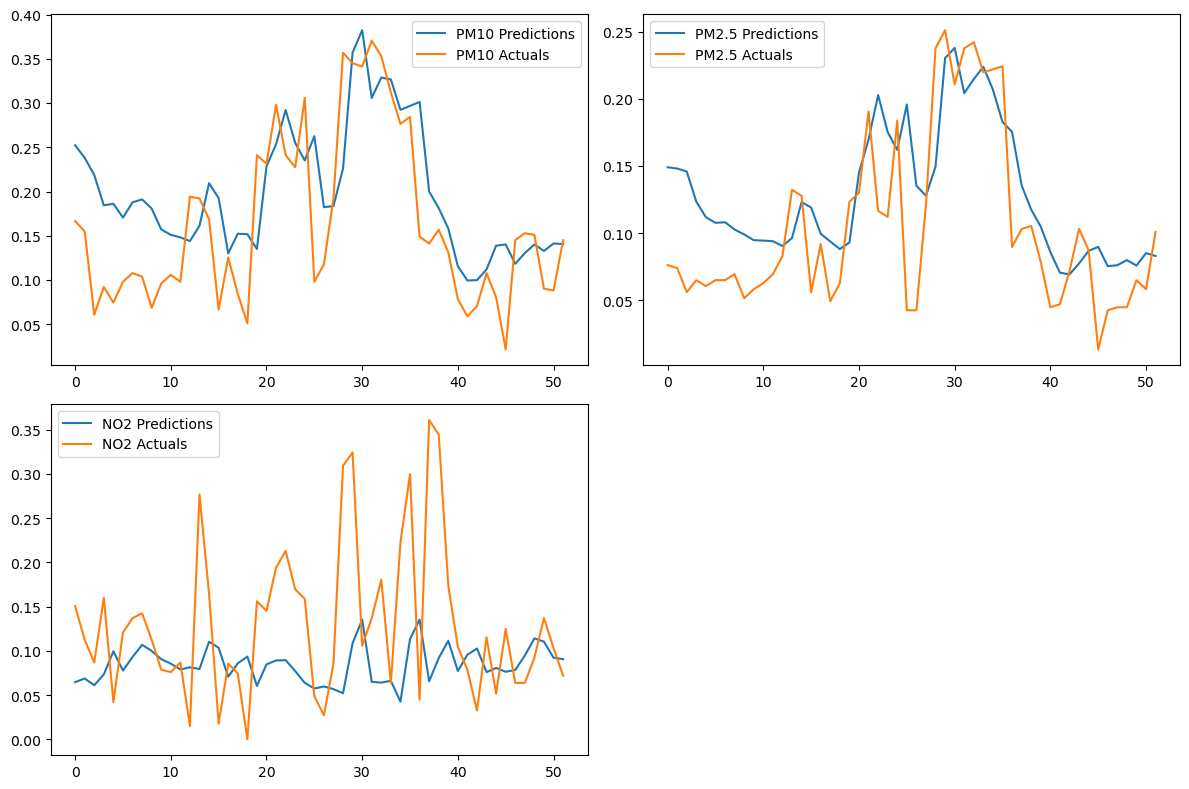

,PM 10 Predictions,PM 10 Actuals,"PM 2,5 Predictions","PM 2,5 Actuals",NO2 Predictions,NO2 Actuals
0,0.252275,0.166667,0.149073,0.076233,0.064621,0.150611
1,0.238178,0.154902,0.148119,0.073991,0.068787,0.112619
2,0.218651,0.060784,0.145908,0.056054,0.061094,0.086839
3,0.184447,0.092157,0.123431,0.065022,0.073409,0.160109
4,0.186223,0.074510,0.111878,0.060538,0.099538,0.042062
5,0.170534,0.098039,0.107696,0.065022,0.077751,0.120760
6,0.187804,0.107843,0.108146,0.065022,0.093086,0.137042
7,0.191139,0.103922,0.102757,0.069507,0.106883,0.142469
8,0.180753,0.068627,0.099034,0.051570,0.099885,0.112619
9,0.157214,0.096078,0.094809,0.058296,0.090651,0.078697


In [103]:
plot_predictions2(model5, X5_test, y5_test)

2/2 [==============================] - 0s 6ms/step


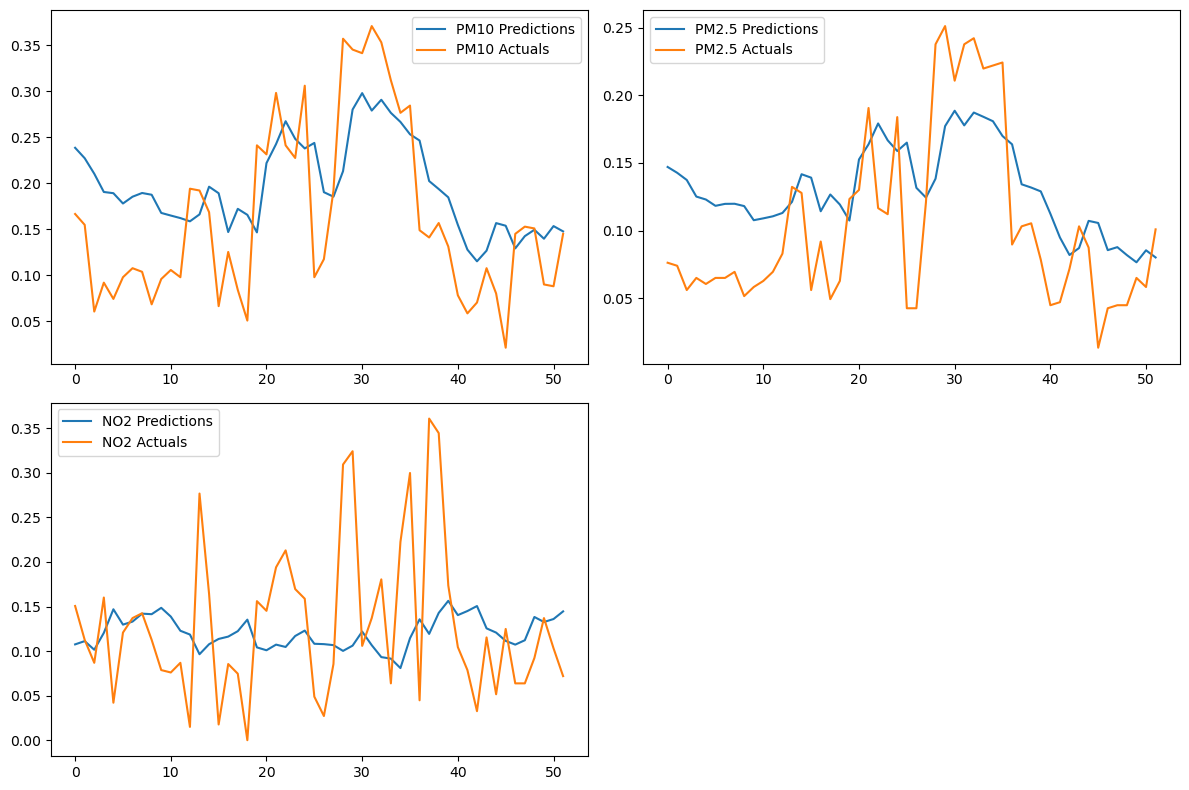

,PM 10 Predictions,PM 10 Actuals,"PM 2,5 Predictions","PM 2,5 Actuals",NO2 Predictions,NO2 Actuals
0,0.238515,0.166667,0.147009,0.076233,0.107525,0.150611
1,0.227202,0.154902,0.142697,0.073991,0.111202,0.112619
2,0.210375,0.060784,0.137398,0.056054,0.101504,0.086839
3,0.190557,0.092157,0.125134,0.065022,0.120426,0.160109
4,0.189228,0.074510,0.122949,0.060538,0.146920,0.042062
5,0.178055,0.098039,0.118295,0.065022,0.129703,0.120760
6,0.185420,0.107843,0.119743,0.065022,0.133107,0.137042
7,0.189457,0.103922,0.119818,0.069507,0.142008,0.142469
8,0.187546,0.068627,0.118103,0.051570,0.141416,0.112619
9,0.167822,0.096078,0.107661,0.058296,0.148546,0.078697


In [98]:
#smaller 
plot_predictions2(model5, X5_test, y5_test)

2/2 [==============================] - 0s 7ms/step


(    Predictions   Actuals
 0      0.275516  0.166667
 1      0.270313  0.154902
 2      0.243768  0.060784
 3      0.198488  0.092157
 4      0.199616  0.074510
 5      0.171790  0.098039
 6      0.187485  0.107843
 7      0.197061  0.103922
 8      0.178919  0.068627
 9      0.155599  0.096078
 10     0.154609  0.105882
 11     0.144176  0.098039
 12     0.121562  0.194118
 13     0.147367  0.192157
 14     0.158992  0.168627
 15     0.147394  0.066667
 16     0.085122  0.125490
 17     0.122490  0.084314
 18     0.118866  0.050980
 19     0.089634  0.241176
 20     0.212082  0.231373
 21     0.223898  0.298039
 22     0.244686  0.241176
 23     0.219138  0.227451
 24     0.206214  0.305882
 25     0.225590  0.098039
 26     0.141864  0.117647
 27     0.157415  0.192157
 28     0.187649  0.356863
 29     0.286700  0.345098
 30     0.287484  0.341176
 31     0.266330  0.370588
 32     0.289308  0.352941
 33     0.263236  0.311765
 34     0.229102  0.276471
 35     0.223424  0.284314
 

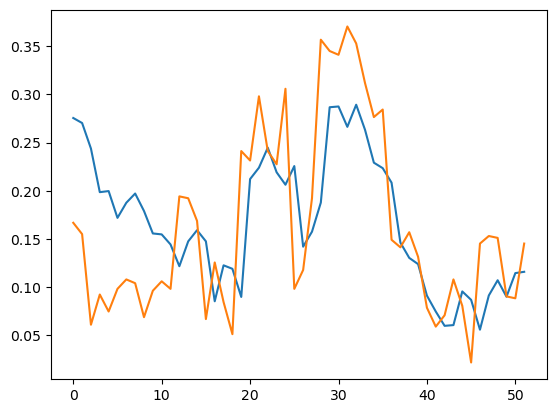

In [76]:
plot_predictions5(model5, X5_test, y5_test)

### Invert Prediction Values

In [63]:
# Reshape 'Predictions' and 'Actuals' to have one feature
predictions = df['Predictions'].values.reshape(-1, 1)
actuals = df['Actuals'].values.reshape(-1, 1)


In [73]:
predictions_inverted = scaler_y.inverse_transform(predictions)
actuals_inverted = scaler_y.inverse_transform(actuals)

In [75]:
df_inverted = pd.DataFrame({
    'Predictions': predictions_inverted.flatten(),
    'Actuals': actuals_inverted.flatten()
})
df_inverted

,Predictions,Actuals
0,17.151331,11.6
1,16.885956,11.0
2,15.532189,6.2
3,13.222870,7.8
4,13.280419,6.9
5,11.861265,8.1
6,12.661733,8.6
7,13.150102,8.4
8,12.224852,6.6
9,11.035548,8.0


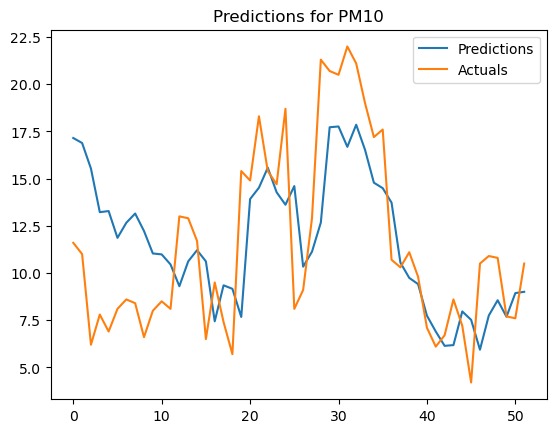

In [83]:
plt.plot(df_inverted['Predictions'])
plt.plot(df_inverted['Actuals'])
plt.title('Predictions for PM10')
plt.legend(['Predictions', 'Actuals'])
plt.savefig('predicts.png')


In [80]:
df_inverted.describe()

,Predictions,Actuals
count,52.000000,52.000000
mean,11.615685,11.407692
std,3.424712,4.813903
min,5.937706,4.200000
25%,8.986202,7.775000
50%,11.081864,10.400000
75%,14.330673,14.750000
max,17.854692,22.000000


# NO2 Predictions

In [17]:

traffic = pd.read_csv('traffic.csv')
traffic_gr= traffic.groupby(['roundedTimestamp', 'Bezeichnung']).sum()
traffic_gr = traffic_gr.reset_index()
traffic_gr
sum_vehicles_list = []

for i, row in traffic_gr.iterrows():
    sum_vehicles = row[2:67].sum()
    sum_vehicles_list.append(sum_vehicles)

traffic_gr['SumVehicles'] = sum_vehicles_list
data = {'intersection' : traffic_gr['Bezeichnung'], 'timestamp' : traffic_gr['roundedTimestamp'], 'sum_vehicles': sum_vehicles_list}
traffic_sum = pd.DataFrame(data = data)
traffic_sum
traffic_sum_total = traffic_sum.groupby('timestamp')['sum_vehicles'].sum()
traffic_sum_total = pd.DataFrame(traffic_sum_total).reset_index()
traffic_sum_total
pred_data1 = traffic_sum_total.merge(weather, how='left', left_on= 'timestamp', right_on='datetime').merge(emissions[['PM10', 'PM2,5', 'NO2', 'datetime']], how='left', left_on= 'timestamp', right_on='datetime' )
pred_data1.drop(columns=['datetime_y', 'datetime_x'], inplace = True)
show(pred_data1)

df_sum = pred_data1.copy()
df_sum.index = pd.to_datetime(df_sum['timestamp'], format='%Y-%m-%d %H:%M:%S')
df_sum[:26]
df_sum['Seconds'] = df_sum.index.map(pd.Timestamp.timestamp)
df_sum
day = 60*60*24
year = 365.2425*day

df_sum['Day sin'] = np.sin(df_sum['Seconds'] * (2* np.pi / day))
df_sum['Day cos'] = np.cos(df_sum['Seconds'] * (2 * np.pi / day))
df_sum['Year sin'] = np.sin(df_sum['Seconds'] * (2 * np.pi / year))
df_sum['Year cos'] = np.cos(df_sum['Seconds'] * (2 * np.pi / year))
df_sum.head()

#drop unwanted columns
df_sum = df_sum.drop(columns = ['timestamp', 'Seconds'])
df_sum = df_sum.fillna(df_sum.mean())
df_sum


scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Separate your DataFrame into features and target variable
X = df_sum.drop(columns=["NO2"])

y = df_sum[["NO2"]]

# Scale the features (X) and target (y) separately
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create a new DataFrame with the scaled features and target variable
df_scaled = pd.DataFrame(data=X_scaled, columns=X.columns, index=df_sum.index)
df_scaled['NO2'] = y
print(df_scaled)

# #move target to be first column
column_to_move = df_scaled.pop('PM10')
df_scaled.insert(0, 'PM10', column_to_move)
df_scaled

def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    #define y
    label = [df_as_np[i+window_size]]
    y.append(label)
  return np.array(X), np.array(y)
X5, y5 = df_to_X_y2(df_scaled)
X5.shape, y5.shape

#split data
X5_train, y5_train = X5[:300], y5[:300]
X5_val, y5_val = X5[300:350], y5[300:350]
X5_test, y5_test = X5[350:], y5[350:]
X5_train.shape, y5_train.shape, X5_val.shape, y5_val.shape, X5_test.shape, y5_test.shape

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adagrad, Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.backend import clear_session

# Clear the Keras session
clear_session()

# Set up checkpoint to save the best model
cp5 = ModelCheckpoint('model_no2/', save_best_only=True)

# Create the model
model_no2 = Sequential()

# Input layer
model_no2.add(InputLayer((6,13)))

model_no2.add(LSTM(64))
model_no2.add(Dropout(0.2))

# Decrease the number of neurons in Dense layers and add L1-Regularization
model_no2.add(Dense(64, activation='relu'))#, kernel_regularizer=l1(0.001)))
model_no2.add(Dense(16, activation='relu'))#, kernel_regularizer=l1(0.001)))


model_no2.add(Dense(1, activation='linear'))

#model5.compile(loss='mean_absolute_error', optimizer=Adagrad(learning_rate=1), metrics=[RootMeanSquaredError()])
model_no2.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_squared_error'])

# Display model summary
model_no2.summary()

#fit model
model_no2.fit(X5_train, y5_train, validation_data=(X5_val, y5_val), epochs=20, callbacks=[cp5])
from tensorflow.keras.models import load_model
model_no2 = load_model('model_no2/')
# prdiction for one target value


from sklearn.metrics import mean_squared_error as mse

def plot_predictions_no2(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y_scaled})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)


model_no2.evaluate(X5_test, y5_test)
plot_predictions_no2(model_no2, X5_test, y5_test)

### Invert Prediction Values
# Reshape 'Predictions' and 'Actuals' to have one feature
predictions = df['Predictions'].values.reshape(-1, 1)
actuals = df['Actuals'].values.reshape(-1, 1)

predictions_inverted = scaler_y.inverse_transform(predictions)
actuals_inverted = scaler_y.inverse_transform(actuals)
df_inverted = pd.DataFrame({
    'Predictions': predictions_inverted.flatten(),
    'Actuals': actuals_inverted.flatten()
})
df_inverted
plt.plot(df_inverted['Predictions'])
plt.plot(df_inverted['Actuals'])
plt.title('Predictions for NO2')
plt.legend(['Predictions', 'Actuals'])
plt.savefig('predicts.png')

df_inverted.describe()

                     sum_vehicles  Luftdruck[hPa]  \
timestamp                                           
2022-08-26 07:00:00      0.152252        0.519231   
2022-08-26 07:30:00      0.416343        0.519231   
2022-08-26 08:00:00      0.246817        0.519231   
2022-08-29 07:00:00      0.180765        0.653846   
2022-08-29 07:30:00      0.439424        0.653846   
...                           ...             ...   
2023-09-02 04:00:00      0.449915        0.596154   
2023-09-02 04:30:00      0.081717        0.615385   
2023-09-14 23:00:00      0.100313        0.653846   
2023-09-14 23:30:00      0.248771        0.653846   
2023-09-15 00:00:00      0.083297        0.538462   

                     Relative Luftfeuchtigkeit[%]  Temperatur[°C]  \
timestamp                                                           
2022-08-26 07:00:00                      0.703540        0.859589   
2022-08-26 07:30:00                      0.690265        0.866438   
2022-08-26 08:00:00               

10/10 [==============================] - 19s 2s/step - loss: 2.1977 - mean_squared_error: 61.4838 - val_loss: 1.2620 - val_mean_squared_error: 14.0242
Epoch 2/20
 6/10 [=================>............] - ETA: 0s - loss: 2.1278 - mean_squared_error: 58.5901

10/10 [==============================] - 13s 1s/step - loss: 2.1483 - mean_squared_error: 60.7950 - val_loss: 1.2542 - val_mean_squared_error: 14.3387
Epoch 3/20
 1/10 [==>...........................] - ETA: 0s - loss: 2.3103 - mean_squared_error: 71.9694

10/10 [==============================] - 13s 1s/step - loss: 2.1431 - mean_squared_error: 60.3107 - val_loss: 1.2519 - val_mean_squared_error: 14.2057
Epoch 4/20
 1/10 [==>...........................] - ETA: 0s - loss: 2.0603 - mean_squared_error: 50.5106

KeyboardInterrupt: 

In [18]:
model_no2.evaluate(X5_test, y5_test)

2/2 [==============================] - 0s 13ms/step - loss: 1.2213 - mean_squared_error: 15.2011


[1.2213366031646729, 15.201141357421875]

In [20]:
y_scaled

array([[0.40705563],
       [0.54545455],
       [0.49389417],
       [0.1614654 ],
       [0.20895522],
       [0.16824966],
       [0.38941655],
       [0.37177748],
       [0.40434193],
       [0.16960651],
       [0.18453189],
       [0.17232022],
       [0.44776119],
       [0.37042062],
       [0.40976934],
       [0.10719132],
       [0.12347354],
       [0.13432836],
       [0.1614654 ],
       [0.16824966],
       [0.55088195],
       [0.59972863],
       [0.53052917],
       [0.31886024],
       [0.27815468],
       [0.30664858],
       [0.26322931],
       [0.19131615],
       [0.28765265],
       [0.39755767],
       [0.3256445 ],
       [0.25373134],
       [0.40841248],
       [0.25439477],
       [0.18046133],
       [0.16282225],
       [0.10854817],
       [0.33107191],
       [0.38127544],
       [0.35006784],
       [0.09769335],
       [0.08683853],
       [0.07327001],
       [0.39891452],
       [0.49660787],
       [0.55359566],
       [0.29715061],
       [0.339

In [21]:
  predictions = model_no2.predict(X5_test).flatten()
  predictions


2/2 [==============================] - 1s 4ms/step


array([0.39489594, 0.3919369 , 0.3864199 , 0.38327828, 0.3989609 ,
       0.37143514, 0.38866597, 0.3914678 , 0.39280832, 0.39129168,
       0.38386366, 0.38862395, 0.39220142, 0.363008  , 0.38837725,
       0.3839672 , 0.35231188, 0.36899325, 0.37219903, 0.35975185,
       0.3789525 , 0.3791597 , 0.38967845, 0.39019668, 0.38562325,
       0.39565033, 0.37237075, 0.36640492, 0.38109997, 0.38829815,
       0.38191646, 0.35862264, 0.3744055 , 0.39254963, 0.37432113,
       0.3974858 , 0.3930549 , 0.35477805, 0.38604325, 0.3877738 ,
       0.37906808, 0.3760831 , 0.3800157 , 0.37442803, 0.39482772,
       0.37888357, 0.39273268, 0.3826909 , 0.3839373 , 0.39622152,
       0.40049493, 0.3977729 ], dtype=float32)

In [24]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions_no2(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y_scaled})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)


In [25]:
model_no2.evaluate(X5_test, y5_test)
plot_predictions_no2(model_no2, X5_test, y5_test)

2/2 [==============================] - 0s 9ms/step


ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
### Invert Prediction Values
# Reshape 'Predictions' and 'Actuals' to have one feature
predictions = df['Predictions'].values.reshape(-1, 1)
actuals = df['Actuals'].values.reshape(-1, 1)

predictions_inverted = scaler_y.inverse_transform(predictions)
actuals_inverted = scaler_y.inverse_transform(actuals)
df_inverted = pd.DataFrame({
    'Predictions': predictions_inverted.flatten(),
    'Actuals': actuals_inverted.flatten()
})
df_inverted
plt.plot(df_inverted['Predictions'])
plt.plot(df_inverted['Actuals'])
plt.title('Predictions for NO2')
plt.legend(['Predictions', 'Actuals'])
plt.savefig('predicts.png')

df_inverted.describe()